# Statistics Without Borders - Covid 19 Twitter Analysis
##### Author: Heli Vora
##### Date: 5/23/2020


# Part 1

The client provided a list of important terms/hashtags that could be used label the tweets as irrelevant and relevant. I followed two approaches here:
1. Using Regular Expressions/conditional statements to filter out relevant tweets according to the list provided by the client
2. Using unsupervised algorithm to cluster similar tweets together


## 1.Data Collection

My initial focus was to support the overall data collection effort. I focused on collecting the data for the month of March. I used the Robotic Process Automation tool UIpath in doing so. Since I have a licensed UIpath tool, it offered a premium connector. Once I enter the tweet criteria - such as location, terms we are looking for etc., the bot will scrape all the required data. At first, I put a criteria based on the hashtags the client provided. However, this criteria resulted in only about 80 tweets for Palo Alto in the month of March. This was happening because the bot was trying to look for exact matches of the client hashtag list. I realized that there would be a lot more tweets that could be speaking about the topic without using the exact list of words. Hence, I modified my approach and pulled all tweets for Palo Alto without for the month of March without any additional criteria. This resulted in about ~140K tweets.


In [2]:
#### Will load all the necessary libraries here
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#### Loading the March 2020 Twitter File
March2020 = pd.read_csv("MasterFile.csv",encoding = 'utf-8')
March2020.head(5)

C:\Users\VoraH\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Device,Ext URL,FullText,HashTags,Location,Retweet,TimeStamp,TweetID,isQuote
0,0,"<a href=""http://twitter.com/download/android"" ...",[],@VPrasadMDMPH The twitter account associated w...,[],"Palo Alto, CA",False,Tue Apr 21 01:41:05 +0000 2020,1.252412e+18,False
1,1,"<a href=""http://twitter.com/download/iphone"" r...","[{'url': 'https://t.co/r8Dok3PtnW', 'expanded_...",Cytokine release syndrome in severe COVID-19 |...,[],"Palo Alto, CA",False,Mon Apr 20 18:37:38 +0000 2020,1.252305e+18,False
2,2,"<a href=""http://twitter.com/download/android"" ...","[{'url': 'https://t.co/tlxzOinpub', 'expanded_...","#RonDeSantis hides ""crucial information"" about...",['RonDeSantis'],"Palo Alto, CA",False,Mon Apr 20 17:37:49 +0000 2020,1.252290e+18,False
3,3,"<a href=""http://twitter.com/download/iphone"" r...",[],@CAG_ID_Doc Great discussion about ARDS phenot...,[],"Palo Alto, CA",False,Mon Apr 20 17:17:12 +0000 2020,1.252285e+18,False
4,4,"<a href=""https://tapbots.com/software/tweetbot...","[{'url': 'https://t.co/B1eb13muVO', 'expanded_...",Super interesting ‘change in mobility’ dashboa...,[],"Palo Alto, CA",False,Mon Apr 20 15:22:58 +0000 2020,1.252256e+18,False


In [4]:
March2020 = March2020[['FullText']]

In [5]:
March2020.shape

(168626, 1)

## 2. Data Cleaning

We can observe that the Data has a lot of emojis, urls, slangs. We want to remove those or replace them.


In [6]:
###Remove all unrequired columns
#March2020.drop(['hashtags','date','City'],axis=1,inplace=True)
March2020.head(2)

,FullText
0,@VPrasadMDMPH The twitter account associated w...
1,Cytokine release syndrome in severe COVID-19 |...


In [7]:
###Remove duplicates and blanks
March2020.dropna(subset = ["FullText"], inplace=True)
March2020.drop_duplicates()
March2020.shape

(168625, 1)

In [8]:

nan_value = float("NaN")

March2020.replace("", nan_value, inplace=True)

March2020.dropna(subset = ["FullText"], inplace=True)

In [9]:
March2020.head(20)

March2020.replace(' ', nan_value, inplace=True)

March2020.dropna(subset = ["FullText"], inplace=True)

In [10]:
March2020.head(20)
March2020.shape

(168625, 1)

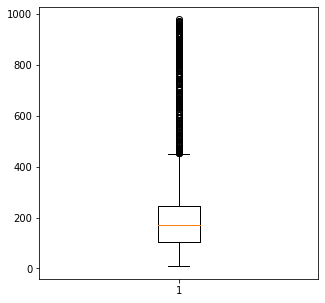

In [11]:
# Checking for the length of the tweets

March2020['pre_clean_len'] = [len(t) for t in March2020.FullText]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(March2020.pre_clean_len)
plt.show()

The maximum length of a tweet is 280. However we can see in the box plot that there are various outliers where length of the tweets is upto 1000. This must be due to presence of urls, emojis, images etc. Let us clean them

In [12]:
March2020[March2020.pre_clean_len > 550].head(5)

,FullText,pre_clean_len
890,@psychmd1 @Lcars24 @bonitalea @joe_kidder2 @ag...,837
2092,@SproutSocial @jamiewo @heymsroti @hiyeshello ...,741
4527,@michellmybell1 @BeckyJohnson222 @SMcwoof @kfu...,879
4528,@michellmybell1 @BeckyJohnson222 @SMcwoof @kfu...,872
4537,@mcfunny @michellmybell1 @TakeThatCDC @crabb_v...,819


In [13]:
March2020 = March2020[March2020.pre_clean_len > 30]

In [14]:
March2020.shape

(167705, 2)

In [15]:
###Removing mentions, hashtages, emojis, urls

###Not removing Numbers to capture covid 19, percentage rate etcs


## Removing HTML encoding
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', text)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z0-9]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()


testing = March2020['FullText']

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
    


In [16]:
clean_df = pd.DataFrame(test_result,columns=['text'])
clean_df.head(20)

,text
0,the twitter account associated with that youtu...
1,cytokine release syndrome in severe covid 19 t...
2,rondesantis hides crucial information about co...
3,id doc great discussion about ards phenotypes ...
4,super interesting change in mobility dashboard...
5,trump and the gop are actually denying needed ...
6,far more covid 19 cases in silicon valley than...
7,we need tech more than ever but that doesn t m...
8,support clinical trials of peginterferon lambd...
9,sorry but his answer is not convincing it is a...


In [17]:


clean_df.replace(" ", nan_value, inplace=True)

clean_df.dropna(subset = ["text"], inplace=True)


In [18]:
clean_df.shape

(167705, 1)

## 3. Using Regex to filter out tweets

The client provided the dictionary/list of important hashtags/words

In [19]:
####Creating a dictionary based on tweets provided by the client

#### I have also added terms with spaces here i.e. if there is word handsanitizer, there is also a word hand sanitizer

#dict1 = ['actnowsavelives','ambulance','beready','clinicians','clinics','clorox','facemasks','handsanitizer','handwashing','medicine','ppe','publichealthisessential','quarantine','quarantined','stayhomeifyouresick','stayhealthy','washyourhands','washyourphone','infectioncontrol','stayhome','flattenthecurve','socialdistance','socialdistancing','stayhomesavelives','coronaviruspandemic','herdimmunity','staythefhome','selfquarantine','risks_symptoms','chronicillness','diamondprincess','epidemic','facetouchchallenge','flu','outbreak','pandemic','superspreaders','virusoutbreak','lungscans','ncip','ards','elderly','agedcare','agedcared','caregiving','eldercare','elderlaw','homecare','homenursing','nursinghome','senior','seniorcare','skillednursing','snf','socialcare','aging','nursinghomeoutbreak','sentiments','cdcfail','endthecoronavirus','factsnotfear','gowuhan','trumpnotfitforoffice','standwithwuhan','trumpvirus','wearethenewsnow','corruptgop','fightagainstcorona','weneedmoretests','wherearethetests','trumpviruscoverup','purge','testvirusnow','votebluenomatterwho2020','trumpisanidiot','pencedemic','complicitcorruptgop','solidarityat8','covidiot','inthistogether','miscellaneous','2019ncov','caronaviruses','caronavirusus','coronaoutbreak','coronavid19','coronavirus','corona','coronaviruschallenge','coronaalert','coronalegshake','coronavirusoutbreak','coronavirusfacts','coronavirusnews','coronavirustruth','coronavirusupdate','covid','covid_19','covid_19pandemic','covid - -19','covid19','covid19-19','covid2019','nationalcoronaviruspandemic','ncov','ncov_2019','ncov2019','novelcoronavirus','sars_cov_2','sars-cov-2','sarscov19','sarscov2','sarsvirus','coronavirusupdates']
dict1 = ['actnowsavelives','ambulance','beready','clinicians','clinics','clorox','facemasks','facecover','sanitizer','handsanitizer','handwashing','medicine','ppe','publichealthisessential','quarantine','quarantined','stayhomeifyouresick','stayhealthy','washyourhands','washyourphone','infectioncontrol','stayhome','flattenthecurve','socialdistance','socialdistancing','stayhomesavelives','coronaviruspandemic','herdimmunity','staythefhome','selfquarantine','risks_symptoms','chronicillness','diamondprincess','epidemic','facetouchchallenge','flu','outbreak','pandemic','superspreaders','virusoutbreak','lungscans','ncip','ards','elderly','agedcare','agedcared','caregiving','eldercare','elderlaw','homecare','homenursing','nursinghome','senior','seniorcare','skillednursing','snf','socialcare','aging','nursinghomeoutbreak','sentiments','cdcfail','endthecoronavirus','factsnotfear','gowuhan','trumpnotfitforoffice','standwithwuhan','trumpvirus','wearethenewsnow','corruptgop','fightagainstcorona','weneedmoretests','wherearethetests','trumpviruscoverup','purge','testvirusnow','votebluenomatterwho2020','trumpisanidiot','pencedemic','complicitcorruptgop','solidarityat8','covidiot','inthistogether','miscellaneous','2019ncov','caronaviruses','caronavirusus','coronaoutbreak','coronavid19','coronavirus','corona','coronaviruschallenge','coronaalert','coronalegshake','coronavirusoutbreak','coronavirusfacts','coronavirusnews','coronavirustruth','coronavirusupdate','covid','covid_19','covid_19pandemic','covid - -19','covid19','covid19-19','covid2019','nationalcoronaviruspandemic','ncov','ncov_2019','ncov2019','novelcoronavirus','sars_cov_2','sars-cov-2','sarscov19','sarscov2','sarsvirus','coronavirusupdates','symptoms','act now save lives','be ready','hand sanitizer','public health','wash your hands','wash my hands','wash hands','wash your phone','infection control','stay home','flatten the curve','social distance','social distancing','stay home save lives','coronavirus pandemic','herd immunity','immunity','self quarantine','risks symptoms','chronic illness','diamond princess','face touch challenge','super spreaders','virus outbreak','lung scans','aged care','aged cared','elder care','elder law','home care','home nursing','nursing home','senior care','skilled nursing','social care','nursing home outbreak','cdc fail','end the coronavirus','facts not fear','go wuhan','trump not fit for office','stand with wuhan','trump virus','we are the news now','corrupt gop','fight against corona','we need more tests','where are the tests','trump virus coverup','test virus now','test kits','testing','more tests','tests','vote blue no matter who 2020','trump is an idiot','complicit corrupt gop','solidarity at 8','in this together','corona outbreak','coronavid 19','corona virus challenge','corona alert','corona leg shake','corona virus outbreak','corona virus facts','corona virus news','corona virus truth','corona virus update','national corona virus pandemic','novel coronavirus','corona virus updates']  
# Converting 
lst = [x.upper() for x in dict1] 
  
# printing output 
print(lst) 

['ACTNOWSAVELIVES', 'AMBULANCE', 'BEREADY', 'CLINICIANS', 'CLINICS', 'CLOROX', 'FACEMASKS', 'FACECOVER', 'SANITIZER', 'HANDSANITIZER', 'HANDWASHING', 'MEDICINE', 'PPE', 'PUBLICHEALTHISESSENTIAL', 'QUARANTINE', 'QUARANTINED', 'STAYHOMEIFYOURESICK', 'STAYHEALTHY', 'WASHYOURHANDS', 'WASHYOURPHONE', 'INFECTIONCONTROL', 'STAYHOME', 'FLATTENTHECURVE', 'SOCIALDISTANCE', 'SOCIALDISTANCING', 'STAYHOMESAVELIVES', 'CORONAVIRUSPANDEMIC', 'HERDIMMUNITY', 'STAYTHEFHOME', 'SELFQUARANTINE', 'RISKS_SYMPTOMS', 'CHRONICILLNESS', 'DIAMONDPRINCESS', 'EPIDEMIC', 'FACETOUCHCHALLENGE', 'FLU', 'OUTBREAK', 'PANDEMIC', 'SUPERSPREADERS', 'VIRUSOUTBREAK', 'LUNGSCANS', 'NCIP', 'ARDS', 'ELDERLY', 'AGEDCARE', 'AGEDCARED', 'CAREGIVING', 'ELDERCARE', 'ELDERLAW', 'HOMECARE', 'HOMENURSING', 'NURSINGHOME', 'SENIOR', 'SENIORCARE', 'SKILLEDNURSING', 'SNF', 'SOCIALCARE', 'AGING', 'NURSINGHOMEOUTBREAK', 'SENTIMENTS', 'CDCFAIL', 'ENDTHECORONAVIRUS', 'FACTSNOTFEAR', 'GOWUHAN', 'TRUMPNOTFITFOROFFICE', 'STANDWITHWUHAN', 'TRUMPVIR

In [20]:
def text_manipulation(words_list, search_string):
    search_result = []
    for sentence in [words_list]:
        words = sentence.replace('.', '').replace(',', '').split(' ')
        [search_result.append(w) for w in words if w.upper() in search_string]
        return(search_result)

def find_keywords(df):
    distance_list = []
    for i in range(0, len(df)):
        d = text_manipulation(df.iloc[i]['text'] , lst)
        distance_list.append(d)
    return distance_list


clean_df['keywords'] = find_keywords(clean_df)
clean_df.head(20)

,text,keywords
0,the twitter account associated with that youtu...,[pandemic]
1,cytokine release syndrome in severe covid 19 t...,[covid]
2,rondesantis hides crucial information about co...,[covid]
3,id doc great discussion about ards phenotypes ...,"[ards, covid, covid]"
4,super interesting change in mobility dashboard...,[covid]
5,trump and the gop are actually denying needed ...,"[covid19, pandemic]"
6,far more covid 19 cases in silicon valley than...,"[covid, covid]"
7,we need tech more than ever but that doesn t m...,[covid]
8,support clinical trials of peginterferon lambd...,[covid]
9,sorry but his answer is not convincing it is a...,[pandemic]


I have created a new column Keywords, which captures the word from the client dictionary which are present in the tweet. The Keyword column contains the exact words that have been matched. I have used an exact match criteria here because otherwise it increased the number of false positives. Example: the word 'orchard' was flagged as the word 'ARD' is in the list to represent Acute Respiratory Disease.

As my next step, I filterd out tweets with no keywords to observe the no. of relevant tweets captured

In [21]:
clean_df['keywords'] = clean_df['keywords'].astype(str)
clean_df.head(20)
key_tweets = clean_df[clean_df.keywords != '[]']
key_tweets.head(3)

,text,keywords
0,the twitter account associated with that youtu...,['pandemic']
1,cytokine release syndrome in severe covid 19 t...,['covid']
2,rondesantis hides crucial information about co...,['covid']


In [22]:
key_tweets.shape

(160124, 2)

We see that a lot of tweets match one or more of the criteria. 
Next, I am doing some exploratory data analysis on the same to identify high frequency words. Another approach we could use is to use conditional statements i.e. when one or more of this combination occur we can mark it as relevant

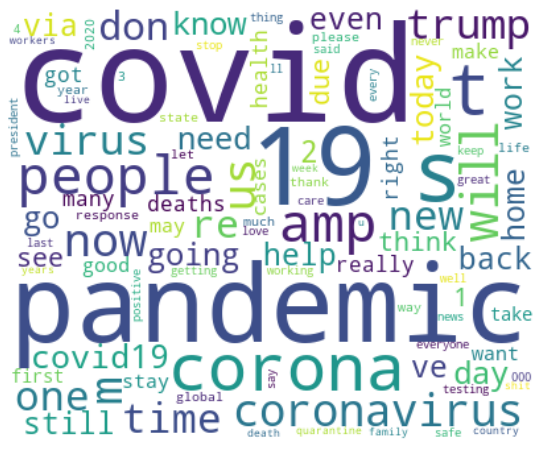

In [23]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq = word_freq.drop(labels=STOPWORDS, errors='ignore')
    word_freq[:20]
    ### Remove Stop words
    
    return word_freq

#Generate word frequencies
word_freq = gen_freq(key_tweets.text.str)

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


We could use conditions such as presence of two or more words together to classify the tweet as relevant or not. 

However, we can miss out on the context of the tweets while doing so. 


## 4 Using unsupervised algorithm to find out key topics of the tweet (Latent Sentiment Analysis)

Another approach that we could try out is using an unsupervised algorithm to extract topics out of the tweet. I will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

In [24]:
import nltk

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z0-9]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [25]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(key_tweets.text))

print(data_words[:1])

[['the', 'twitter', 'account', 'associated', 'with', 'that', 'youtube', 'channel', 'pandemic', 'is', 'interesting', 'it', 'certainly', 'slanted', 'towards', 'one', 'point', 'of', 'view', 'fear', 'this', 'will', 'turn', 'into', 'fight', 'over', 'who', 'gets', 'to', 'be', 'right', 'not', 'search', 'for', 'truth', 'that', 'in', 'itself', 'is', 'dangerous']]


In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'twitter', 'account', 'associated', 'with', 'that', 'youtube_channel', 'pandemic', 'is', 'interesting', 'it', 'certainly', 'slanted', 'towards', 'one', 'point', 'of', 'view', 'fear', 'this', 'will', 'turn', 'into', 'fight', 'over', 'who', 'gets', 'to', 'be', 'right', 'not', 'search', 'for', 'truth', 'that', 'in', 'itself', 'is', 'dangerous']


In [28]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
nlp = spacy.load('en_core_web_sm')

In [30]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['twitter', 'associate', 'interesting', 'certainly', 'slant', 'point', 'view', 'fear', 'turn', 'fight', 'get', 'right', 'search', 'truth', 'dangerous']]


In [31]:
#Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [32]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('associate', 1),
  ('certainly', 1),
  ('dangerous', 1),
  ('fear', 1),
  ('fight', 1),
  ('get', 1),
  ('interesting', 1),
  ('point', 1),
  ('right', 1),
  ('search', 1),
  ('slant', 1),
  ('truth', 1),
  ('turn', 1),
  ('twitter', 1),
  ('view', 1)]]

In [33]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [34]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.110*"pandemic" + 0.017*"know" + 0.016*"amp" + 0.014*"think" + '
  '0.013*"help" + 0.012*"want" + 0.011*"even" + 0.011*"thank" + 0.010*"really" '
  '+ 0.010*"live"'),
 (1,
  '0.031*"people" + 0.022*"take" + 0.020*"make" + 0.016*"work" + 0.013*"need" '
  '+ 0.012*"due" + 0.012*"year" + 0.010*"die" + 0.009*"let" + 0.008*"use"'),
 (2,
  '0.045*"covid" + 0.028*"go" + 0.027*"get" + 0.018*"corona" + 0.018*"say" + '
  '0.016*"time" + 0.013*"see" + 0.012*"day" + 0.012*"today" + 0.011*"new"')]


Interpreting this:

(9,
  '0.104*"corona" + 0.040*"right" + 0.040*"also" + 0.029*"job" + 0.026*"close" '
  '+ 0.020*"vaccine" + 0.019*"fight" + 0.018*"worker" + 0.016*"fuck" + '
  '0.015*"question"
  
It means the top 10 keywords that contribute to this topic are: corona, vaccine, worker. and so on and the weight of ‘corona’ on topic 9
is 0.104

The weights reflect how important a keyword is to that topic.

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.922259599327074

Coherence Score:  0.30319131899606583


In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\VoraH\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.361760  0.012607       1        1  36.682007
1      0.169847 -0.316339       2        1  32.240826
0      0.191913  0.303731       3        1  31.077171, topic_info=     Category          Freq       Term         Total  loglift  logprob
50    Default  55636.000000   pandemic  55636.000000  30.0000  30.0000
65    Default  26950.000000      covid  26950.000000  29.0000  29.0000
89    Default  16136.000000     people  16136.000000  28.0000  28.0000
87    Default  16615.000000         go  16615.000000  27.0000  27.0000
5     Default  16305.000000        get  16305.000000  26.0000  26.0000
478   Default  11388.000000       take  11388.000000  25.0000  25.0000
59    Default  10480.000000       make  10480.000000  24.0000  24.0000
469   Default  10713.000000     corona  10713.000000  23.0000  23.0000
598   Default  10476.000000        say  10476.000000  22.0000  22.0000
184   Default   8489.000000       know   8489.000000  21.0000  21.0000
176   Default   8577.000000       work   8577.000000  20.0000  20.0000
452   Default   9556.000000       time   9556.000000  19.0000  19.0000
191   Default   8070.000000        amp   8070.000000  18.0000  18.0000
396   Default   7992.000000        see   7992.000000  17.0000  17.0000
146   Default   6851.000000      think   6851.000000  16.0000  16.0000
49    Default   7013.000000       need   7013.000000  15.0000  15.0000
242   Default   6634.000000       help   6634.000000  14.0000  14.0000
639   Default   7355.000000        day   7355.000000  13.0000  13.0000
307   Default   6382.000000        due   6382.000000  12.0000  12.0000
235   Default   6248.000000       year   6248.000000  11.0000  11.0000
207   Default   5992.000000       want   5992.000000  10.0000  10.0000
475   Default   6876.000000      today   6876.000000   9.0000   9.0000
376   Default   6535.000000        new   6535.000000   8.0000   8.0000
353   Default   6409.000000      virus   6409.000000   7.0000   7.0000
47    Default   6408.000000      death   6408.000000   6.0000   6.0000
456   Default   5418.000000       even   5418.000000   5.0000   5.0000
34    Default   5402.000000      thank   5402.000000   4.0000   4.0000
225   Default   6249.000000       come   6249.000000   3.0000   3.0000
142   Default   5263.000000     really   5263.000000   2.0000   2.0000
156   Default   5141.000000       live   5141.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
184    Topic3   8488.919922       know   8489.770508   1.1686  -4.0848
191    Topic3   8069.998535        amp   8070.825195   1.1686  -4.1354
146    Topic3   6850.962891      think   6851.798340   1.1686  -4.2992
242    Topic3   6633.748535       help   6634.589844   1.1686  -4.3314
207    Topic3   5991.869629       want   5992.703125   1.1686  -4.4332
34     Topic3   5402.019531      thank   5402.839844   1.1685  -4.5368
456    Topic3   5418.135254       even   5418.965332   1.1685  -4.5338
142    Topic3   5262.417480     really   5263.256348   1.1685  -4.5630
156    Topic3   5140.925781       live   5141.765137   1.1685  -4.5864
70     Topic3   4552.350098       many   4553.175293   1.1685  -4.7079
8      Topic3   4149.515137      right   4150.345703   1.1685  -4.8006
603    Topic3   4091.012695       life   4091.837402   1.1685  -4.8148
109    Topic3   3991.337646       much   3992.178223   1.1685  -4.8395
1020   Topic3   3747.568359       stop   3748.401367   1.1685  -4.9025
255    Topic3   3775.118164      month   3775.967285   1.1685  -4.8952
86     Topic3   3658.962891     global   3659.787842   1.1685  -4.9264
422    Topic3   3183.276367     friend   3184.110352   1.1684  -5.0657
170    Topic3   3034.680664       love   3035.484131   1.1684  -5.1135
98     Topic3   3021.063232      world   3021.904541   1.1684  -5.1180
1534   Topic3   3104.886719        put   3105.754639   1.1684  -5.